# WTS Pipeline Integration with UMAP, HDBSCAN
Exploratory notebook for working on birdnet embeddings

### Imports and Setup

In [1]:
import pandas as pd
import os
import numpy as np
from annotation_post_processing import *
import warnings
warnings.filterwarnings("ignore")

### Statistics

In [2]:
from statistics_1 import *

In [3]:
class_stats_original = [pd.read_csv(f"./cosmos_annotations/stats/{i}_original.csv", index_col=0) for i in range(5)]
for i in range(5):
    class_stats_original[i]["MODEL"] = "original"
    class_stats_original[i] = class_stats_original[i][class_stats_original[i]["MANUAL ID"] != "Lipaugus vociferans"].reset_index(drop=True)
class_stats_filtered_all = dict()
all_class_stats = dict()

for a in [5, 10, 20, 50, 100, 200, 500]:
    for b in [5, 10, 20, 50, 100, 200, 500]:
        class_stats_filtered_all[a,b] = [pd.read_csv(f"./cosmos_annotations/stats/{i}_{a}_{b}_filtered.csv", index_col=0) for i in range(5)]
        for i in range(5):
            class_stats_filtered_all[a,b][i]["MODEL"] = "filtered"
            class_stats_filtered_all[a,b][i] = class_stats_filtered_all[a,b][i][class_stats_filtered_all[a,b][i]["MANUAL ID"] != "Lipaugus vociferans"].reset_index(drop=True)
        all_class_stats[a,b] = [pd.concat([class_stats_original[i], class_stats_filtered_all[a,b][i]]) for i in range(5)]
        print(f"Finished with a = {a} and b = {b}")

Finished with a = 5 and b = 5
Finished with a = 5 and b = 10
Finished with a = 5 and b = 20
Finished with a = 5 and b = 50
Finished with a = 5 and b = 100
Finished with a = 5 and b = 200
Finished with a = 5 and b = 500
Finished with a = 10 and b = 5
Finished with a = 10 and b = 10
Finished with a = 10 and b = 20
Finished with a = 10 and b = 50
Finished with a = 10 and b = 100
Finished with a = 10 and b = 200
Finished with a = 10 and b = 500
Finished with a = 20 and b = 5
Finished with a = 20 and b = 10
Finished with a = 20 and b = 20
Finished with a = 20 and b = 50
Finished with a = 20 and b = 100
Finished with a = 20 and b = 200
Finished with a = 20 and b = 500
Finished with a = 50 and b = 5
Finished with a = 50 and b = 10
Finished with a = 50 and b = 20
Finished with a = 50 and b = 50
Finished with a = 50 and b = 100
Finished with a = 50 and b = 200
Finished with a = 50 and b = 500
Finished with a = 100 and b = 5
Finished with a = 100 and b = 10
Finished with a = 100 and b = 20
Finis

In [4]:
class_stats_original[0]

,MANUAL ID,TRUE POSITIVE,FALSE NEGATIVE,FALSE POSITIVE,PRECISION,RECALL,F1,MODEL
0,Celeus grammicus,113.384240,146.143923,257.177324,0.3060,0.4369,0.3599,original
1,Microcerculus marginatus,352.578594,240.512721,123.540748,0.7405,0.5945,0.6595,original
2,Myioborus miniatus,339.125125,126.491066,155.562812,0.6855,0.7283,0.7063,original
3,Ramphastos tucanus,874.601882,347.855624,156.701610,0.8481,0.7154,0.7761,original
4,Thraupis episcopus,351.393810,87.187324,348.766463,0.5019,0.8012,0.6172,original
5,Tolmomyias sulphurescens,221.261066,77.257619,231.771383,0.4884,0.7412,0.5888,original
6,Trogon viridis,431.089093,291.178118,299.116689,0.5904,0.5969,0.5936,original
7,Turdus leucomelas,662.576463,174.338776,227.477143,0.7444,0.7917,0.7673,original
8,Xiphorhynchus guttatus,590.614512,156.416304,218.267279,0.7302,0.7906,0.7592,original
9,Zonotrichia capensis,408.120113,136.352880,128.272789,0.7609,0.7496,0.7552,original


In [5]:
class_stats_filtered_all[5,5][0]

,MANUAL ID,TRUE POSITIVE,FALSE NEGATIVE,FALSE POSITIVE,PRECISION,RECALL,F1,MODEL
0,Celeus grammicus,92.863265,153.969569,128.976485,0.4186,0.3762,0.3963,filtered
1,Microcerculus marginatus,272.468980,285.032336,83.254853,0.7660,0.4887,0.5967,filtered
2,Myioborus miniatus,289.066463,176.549728,135.830658,0.6803,0.6208,0.6492,filtered
3,Ramphastos tucanus,555.790408,394.306440,101.559501,0.8455,0.5850,0.6915,filtered
4,Thraupis episcopus,342.860930,95.720204,288.020113,0.5435,0.7818,0.6412,filtered
5,Tolmomyias sulphurescens,210.381950,70.928821,208.650454,0.5021,0.7479,0.6008,filtered
6,Trogon viridis,413.989025,308.278186,198.449161,0.6760,0.5732,0.6203,filtered
7,Turdus leucomelas,407.895828,390.019592,127.366939,0.7620,0.5112,0.6119,filtered
8,Xiphorhynchus guttatus,449.883968,281.891361,113.578980,0.7984,0.6148,0.6947,filtered
9,Zonotrichia capensis,341.411497,194.920907,85.074059,0.8005,0.6366,0.7092,filtered


In [6]:
all_class_stats[5,5][0]

,MANUAL ID,TRUE POSITIVE,FALSE NEGATIVE,FALSE POSITIVE,PRECISION,RECALL,F1,MODEL
0,Celeus grammicus,113.384240,146.143923,257.177324,0.3060,0.4369,0.3599,original
1,Microcerculus marginatus,352.578594,240.512721,123.540748,0.7405,0.5945,0.6595,original
2,Myioborus miniatus,339.125125,126.491066,155.562812,0.6855,0.7283,0.7063,original
3,Ramphastos tucanus,874.601882,347.855624,156.701610,0.8481,0.7154,0.7761,original
4,Thraupis episcopus,351.393810,87.187324,348.766463,0.5019,0.8012,0.6172,original
5,Tolmomyias sulphurescens,221.261066,77.257619,231.771383,0.4884,0.7412,0.5888,original
6,Trogon viridis,431.089093,291.178118,299.116689,0.5904,0.5969,0.5936,original
7,Turdus leucomelas,662.576463,174.338776,227.477143,0.7444,0.7917,0.7673,original
8,Xiphorhynchus guttatus,590.614512,156.416304,218.267279,0.7302,0.7906,0.7592,original
9,Zonotrichia capensis,408.120113,136.352880,128.272789,0.7609,0.7496,0.7552,original


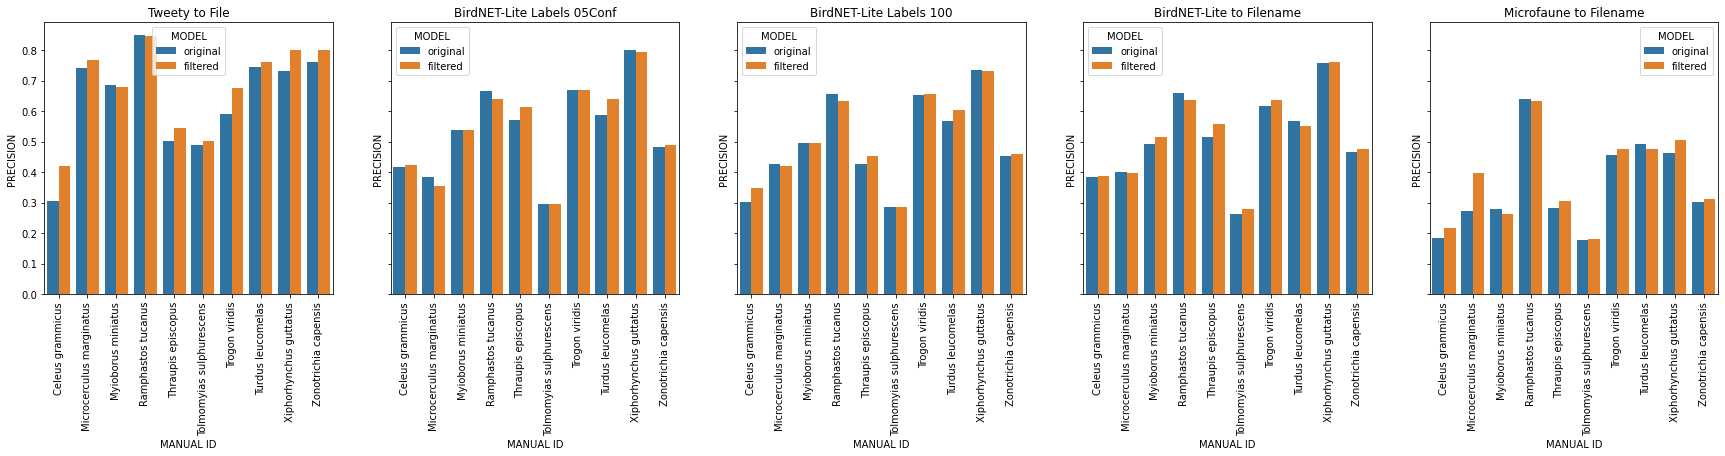

In [7]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting each model separately
figure, axes = plt.subplots(1, len(class_stats_original), figsize = (30, 5), sharex = False, sharey = True)

x = 0
model_list = ["Tweety to File", "BirdNET-Lite Labels 05Conf", "BirdNET-Lite Labels 100", "BirdNET-Lite to Filename", "Microfaune to Filename"]

for model in model_list:
    plot = sns.barplot(ax = axes[x], data = all_class_stats[5,5][x], x = "MANUAL ID", y = "PRECISION", hue = "MODEL")
    for label in plot.get_xticklabels():
        label.set_rotation(90)
    plot.set(title = model)
    x += 1

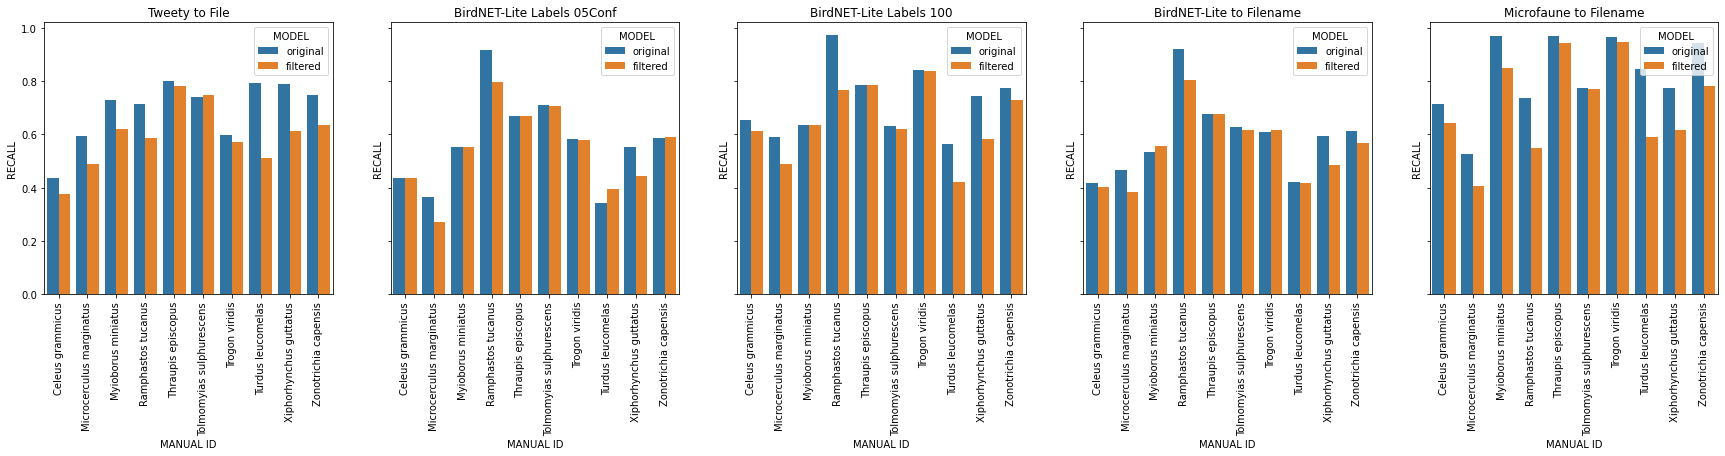

In [8]:
figure, axes = plt.subplots(1, len(class_stats_original), figsize = (30, 5), sharex = False, sharey = True)

x = 0

for model in model_list:
    plot = sns.barplot(ax = axes[x], data = all_class_stats[5,5][x], x = "MANUAL ID", y = "RECALL", hue = "MODEL")
    for label in plot.get_xticklabels():
        label.set_rotation(90)
    plot.set(title = model)
    x += 1

### Finding Best Statistics

In [9]:
best_stats = class_stats_original.copy()
for i in range(5):
    best_stats[i] = pd.DataFrame(best_stats[i]["MANUAL ID"])
    best_stats[i][["Best Precision", "a", "b"]] = [0, 0, 0]

best_stats[0]

,MANUAL ID,Best Precision,a,b
0,Celeus grammicus,0,0,0
1,Microcerculus marginatus,0,0,0
2,Myioborus miniatus,0,0,0
3,Ramphastos tucanus,0,0,0
4,Thraupis episcopus,0,0,0
5,Tolmomyias sulphurescens,0,0,0
6,Trogon viridis,0,0,0
7,Turdus leucomelas,0,0,0
8,Xiphorhynchus guttatus,0,0,0
9,Zonotrichia capensis,0,0,0


In [28]:
best_precisions = [[0 for j in range(10)] for i in range(5)]
best_a = [[0 for j in range(10)] for i in range(5)]
best_b = [[0 for j in range(10)] for i in range(5)]

species = class_stats_original[0]["MANUAL ID"].to_list()

for a in [5, 10, 20, 50, 100, 200, 500]:
    for b in [5, 10, 20, 50, 100, 200, 500]:
        for i in range(5):
            for j in range(10):
                df = class_stats_filtered_all[a,b][i]
                try:
                    if len(df[df["MANUAL ID"] == species[j]]) > 0 and df[df["MANUAL ID"] == species[j]]["PRECISION"].iloc[0] > best_precisions[i][j]:
                        best_precisions[i][j] = class_stats_filtered_all[a,b][i].iloc[j,4]
                        best_a[i][j] = a
                        best_b[i][j] = b
                except:
                    continue
        print(f"Finished finding best with {a} and {b}")

Finished finding best with 5 and 5
Finished finding best with 5 and 10
Finished finding best with 5 and 20
Finished finding best with 5 and 50
Finished finding best with 5 and 100
Finished finding best with 5 and 200
Finished finding best with 5 and 500
Finished finding best with 10 and 5
Finished finding best with 10 and 10
Finished finding best with 10 and 20
Finished finding best with 10 and 50
Finished finding best with 10 and 100
Finished finding best with 10 and 200
Finished finding best with 10 and 500
Finished finding best with 20 and 5
Finished finding best with 20 and 10
Finished finding best with 20 and 20
Finished finding best with 20 and 50
Finished finding best with 20 and 100
Finished finding best with 20 and 200
Finished finding best with 20 and 500
Finished finding best with 50 and 5
Finished finding best with 50 and 10
Finished finding best with 50 and 20
Finished finding best with 50 and 50
Finished finding best with 50 and 100
Finished finding best with 50 and 200
F

In [48]:
cols = ["MANUAL ID","a","b","Original Precision","Best Precision","Original Recall","Final Recall"]

for i in range(5):
    best_stats[i]["Best Precision"] = best_precisions[i]
    best_stats[i]["a"] = best_a[i]
    best_stats[i]["b"] = best_b[i]
    best_stats[i]["Original Precision"] = class_stats_original[i]["PRECISION"]
    best_stats[i]["Original Recall"] = class_stats_original[i]["RECALL"]
    best_stats[i]["Final Recall"] = 0
    for j in range(10):
        df = class_stats_filtered_all[best_a[i][j],best_b[i][j]][i]
        stat = df[df["MANUAL ID"] == species[j]]["RECALL"].iloc[0]
        best_stats[i]["Final Recall"].iloc[j] = stat
    best_stats[i] = best_stats[i][cols]

In [49]:
best_stats[0]

,MANUAL ID,a,b,Original Precision,Best Precision,Original Recall,Final Recall
0,Celeus grammicus,5,100,0.3060,0.4757,0.4369,0.3792
1,Microcerculus marginatus,5,20,0.7405,0.7737,0.5945,0.5112
2,Myioborus miniatus,50,100,0.6855,0.7226,0.7283,0.5321
3,Ramphastos tucanus,500,5,0.8481,0.8481,0.7154,0.7154
4,Thraupis episcopus,5,200,0.5019,0.6663,0.8012,0.5228
5,Tolmomyias sulphurescens,500,100,0.4884,0.5770,0.7412,0.5028
6,Trogon viridis,5,200,0.5904,0.6784,0.5969,0.5502
7,Turdus leucomelas,5,500,0.7444,0.7651,0.7917,0.5928
8,Xiphorhynchus guttatus,5,500,0.7302,0.8212,0.7906,0.7214
9,Zonotrichia capensis,500,20,0.7609,0.8290,0.7496,0.5383


In [50]:
best_stats[1]

,MANUAL ID,a,b,Original Precision,Best Precision,Original Recall,Final Recall
0,Celeus grammicus,5,100,0.4162,0.4294,0.4367,0.4231
1,Microcerculus marginatus,5,20,0.3843,0.3581,0.3635,0.3030
2,Myioborus miniatus,5,5,0.5391,0.5391,0.5522,0.5522
3,Ramphastos tucanus,10,500,0.6646,0.7268,0.9189,0.0625
4,Thraupis episcopus,5,200,0.5721,0.6175,0.6699,0.5722
5,Tolmomyias sulphurescens,5,200,0.2955,0.3247,0.7120,0.6613
6,Trogon viridis,20,5,0.6694,0.6701,0.5826,0.5797
7,Turdus leucomelas,5,5,0.5857,0.6381,0.3410,0.3942
8,Xiphorhynchus guttatus,5,200,0.7998,0.8108,0.5513,0.5022
9,Zonotrichia capensis,5,5,0.4826,0.4900,0.5885,0.5906


In [51]:
best_stats[2]

,MANUAL ID,a,b,Original Precision,Best Precision,Original Recall,Final Recall
0,Celeus grammicus,5,200,0.3026,0.4752,0.6535,1.0000
1,Microcerculus marginatus,5,50,0.4280,0.4214,0.5901,0.4843
2,Myioborus miniatus,50,100,0.4946,0.4981,0.6351,0.6269
3,Ramphastos tucanus,10,500,0.6552,0.7257,0.9726,0.0593
4,Thraupis episcopus,5,200,0.4256,0.5507,0.7872,0.6367
5,Tolmomyias sulphurescens,5,200,0.2851,0.3163,0.6336,0.6412
6,Trogon viridis,20,200,0.6514,0.6599,0.8416,0.8709
7,Turdus leucomelas,5,5,0.5671,0.6050,0.5625,0.4214
8,Xiphorhynchus guttatus,100,5,0.7346,0.7499,0.7440,0.6835
9,Zonotrichia capensis,5,5,0.4526,0.4598,0.7733,0.7309


In [52]:
best_stats[3]

,MANUAL ID,a,b,Original Precision,Best Precision,Original Recall,Final Recall
0,Celeus grammicus,5,100,0.3836,0.4241,0.4182,0.4201
1,Microcerculus marginatus,5,50,0.4005,0.3988,0.4678,0.3787
2,Myioborus miniatus,50,100,0.4927,0.5226,0.5326,0.5078
3,Ramphastos tucanus,10,500,0.6602,0.7268,0.9222,0.0625
4,Thraupis episcopus,5,200,0.5136,0.5898,0.6766,0.5601
5,Tolmomyias sulphurescens,5,500,0.2643,0.6705,0.6264,0.6967
6,Trogon viridis,20,5,0.6172,0.6377,0.6077,0.6163
7,Turdus leucomelas,500,50,0.5667,0.7631,0.4224,0.4256
8,Xiphorhynchus guttatus,100,5,0.7589,0.7802,0.5936,0.5454
9,Zonotrichia capensis,5,5,0.4648,0.4741,0.6119,0.5677


In [53]:
best_stats[4]

,MANUAL ID,a,b,Original Precision,Best Precision,Original Recall,Final Recall
0,Celeus grammicus,5,100,0.1853,0.3392,0.7152,0.5330
1,Microcerculus marginatus,5,5,0.2735,0.3975,0.5255,0.4062
2,Myioborus miniatus,5,200,0.2797,0.3096,0.9701,0.0796
3,Ramphastos tucanus,5,500,0.6402,0.6663,0.7367,0.1374
4,Thraupis episcopus,5,200,0.2808,0.4558,0.9683,0.5460
5,Tolmomyias sulphurescens,500,100,0.1770,0.2479,0.7759,0.4120
6,Trogon viridis,5,500,0.4547,0.5879,0.9658,0.1253
7,Turdus leucomelas,500,50,0.4913,0.5378,0.8468,0.7540
8,Xiphorhynchus guttatus,100,50,0.4621,0.5527,0.7749,0.7066
9,Zonotrichia capensis,5,500,0.3007,0.3978,0.9445,0.2491
